# Медианные фильтры

In [1]:
import numpy as np
from PIL import Image

## Подготовка

In [30]:
# Загрузим тестовое изображение и представим его в виде np.array
image = Image.open("samples/Original.bmp")
image = np.array(image)

# Для ускорения проверки обрежем исходное изображение
SMALLER_SIZE = 100
image = image[:SMALLER_SIZE, :SMALLER_SIZE, :]

In [31]:
# Будем работать с фильтрами радиуса R
R = 25

# Соответствующий фильтр будет иметь размер FILTER_SIZE
FILTER_SIZE = 2 * R + 1

## Реализации

В данном блоке будут рассмотрены различные реализации медианных фильтров, а затем будет приведено их сравнение

### OpenCV: medianBlur

В библиотеке OpenCV уже присутствует реализация медианного фильтра, возьмём её в качестве эталона для проверки самописных алгоритмов

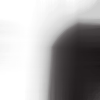

In [32]:
import cv2

blurred_etalon = cv2.medianBlur(image, FILTER_SIZE)

# Посмотрим на результат
Image.fromarray(blurred_etalon)

### Наивный алгоритм

Наивный алгоритм заключается в том, что мы для каждого окна фильтра ищем медиану путём сортировки яркостей пикселей

In [33]:
from algorithms import NaiveMedianFilter

blurred_naive = NaiveMedianFilter().apply(image, R)

100%|██████████| 100/100 [00:01<00:00, 72.42it/s]


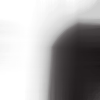

In [34]:
# Посмотрим на результат
Image.fromarray(blurred_naive)

In [35]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_naive))
print("Результаты работы алгоритмов совпадают")

Результаты работы алгоритмов совпадают


### Huang et al.

Ссылка на оригинальную статью: https://www.uio.no/studier/emner/matnat/ifi/INF2310/v20/undervisningsmateriale/litteratur/huang-etal-median.pdf

Идея алгоритма состоит в использовании гистограммы значений в текущем окне фильтра для быстрого нахождения медианы

In [254]:
from algorithms import HuangMedianFilter

In [255]:
padded_image = HuangMedianFilter.pad_image(image, R)

In [256]:
h, w, c = image.shape

hist_values_count = 256

In [257]:
th = (FILTER_SIZE ** 2) // 2
median = 0

result = np.zeros_like(image)

In [258]:
from tqdm import trange

for color in [0, 1, 2]:
    for i in trange(h):
        # Build new histogram for each row
        hist = np.zeros(256)

        ltmdn = 0
        median = 0

        for j in range(w):
            # Starting window
            if j == 0:
                # Fill initial histogram
                for i_ in range(i, i + FILTER_SIZE):
                    for j_ in range(j, j + FILTER_SIZE):
                        hist[padded_image[i_, j_, color]] += 1

                # Find starting median
                median = 0
                while ltmdn + hist[median] <= th:
                    ltmdn += hist[median]
                    median += 1

                result[i, j, color] = median
                
            if j + 1 == w:
                break

            # Move to the next window j+1
            prev_left_column = padded_image[i:i+FILTER_SIZE, j, color]
            next_right_column = padded_image[i:i+FILTER_SIZE, j+FILTER_SIZE, color]

            for i_ in range(0, 0 + FILTER_SIZE):
                value = prev_left_column[i_]

                hist[value] -= 1
                if value < median:
                    ltmdn -= 1

                value = next_right_column[i_]

                hist[value] += 1
                if value < median:
                    ltmdn += 1

            if ltmdn > th:
                median -= 1
                ltmdn -= hist[median]

                while ltmdn > th:
                    median -= 1
                    ltmdn -= hist[median]
            else:
                while ltmdn + hist[median] <= th:
                    ltmdn += hist[median]
                    median += 1

            # Median is correct
            result[i, j + 1, color] = median

100%|██████████| 100/100 [00:01<00:00, 87.12it/s]


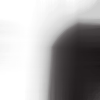

In [259]:
Image.fromarray(result)

In [260]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, result))
print("Результаты работы алгоритмов совпадают")

Результаты работы алгоритмов совпадают


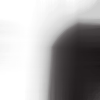

In [219]:
Image.fromarray(blurred_etalon)

In [183]:
np.equal(blurred_etalon[:, :, 0], result[:, :, 0])

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [116]:
blurred_etalon.shape

(100, 100, 3)

In [117]:
100 * 100 * 3

30000